In [ ]:
!pip install pandas scikit-learn nltk textblob gradio textblob xlrd 

In [2]:
import pandas as pd
import numpy as np
import re
import string
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91752\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91752\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91752\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

df = pd.read_excel('ai_dev_assignment_tickets_complex_1000.xls', engine='xlrd')    # For old .xls format
df.head()


,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


# Preprocessing

In [4]:
df.shape

(1000, 5)

In [5]:
df.isnull().sum()

ticket_id         0
ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64

In [6]:

df.dropna(subset=['ticket_text', 'issue_type', 'urgency_level', 'product'], inplace=True)
df.reset_index(drop=True, inplace=True)


In [7]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['ticket_text'].apply(preprocess_text)


In [8]:
# Feature Engineering

df['text_length'] = df['clean_text'].apply(len)
df['sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Combine all features
X = np.hstack([X_tfidf.toarray(), df[['text_length', 'sentiment']].values])


In [9]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, df['issue_type'], test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, df['urgency_level'], test_size=0.2, random_state=42)


# Model Building

In [10]:

issue_model = RandomForestClassifier()
urgency_model = LogisticRegression(max_iter=500)

issue_model.fit(X_train1, y_train1)
urgency_model.fit(X_train2, y_train2)


LogisticRegression(max_iter=500)

In [11]:

print("Issue Type Classification Report:\n", classification_report(y_test1, issue_model.predict(X_test1)),"\n","\n")
print("Urgency Level Classification Report:\n", classification_report(y_test2, urgency_model.predict(X_test2)))


Issue Type Classification Report:
                     precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        23
   Billing Problem       1.00      1.00      1.00        19
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        29
     Late Delivery       1.00      1.00      1.00        17
    Product Defect       1.00      1.00      1.00        30
        Wrong Item       1.00      1.00      1.00        23

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166
 
 

Urgency Level Classification Report:
               precision    recall  f1-score   support

        High       0.37      0.30      0.33        66
         Low       0.24      0.30      0.27        43
      Medium       0.31      0.32      0.31        57

    accuracy                           0.3

In [12]:
# Entity Extraction
def extract_entities(text, prod_list):
    additional_products = [
    "smartphone", "laptop", "tablet", "monitor", "printer", "router", "power bank", "headphones", "webcam",
    "refrigerator", "microwave", "air conditioner", "washing machine", "vacuum cleaner", "water purifier", 
    "smart TV", "gaming console", "VR headset", "home theater system", "CRM software", "ERP system",
    "cloud storage", "VPN", "POS software", "CMS", "video conferencing tool", "inverter", "solar panel",
    "generator", "transformer", "PLC", "CNC machine", "car battery", "engine oil", "brake pad", "GPS navigator",
    "t-shirt", "jeans", "shoes", "cosmetics", "groceries", "books", "blood pressure monitor", "glucometer",
    "thermometer", "PPE kit", "hospital bed", "wheelchair"
]

    product_list= list(set(list(prod_list) + additional_products))

    entities = {}
    
    # Product
    entities['product'] = [prod for prod in product_list if prod.lower() in text.lower()]
    
    # Dates
    date_matches = re.findall(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', text)
    entities['dates'] = date_matches
    
    # Complaint keywords
    keywords = [
    "broken", "not working", "malfunction", "damaged", "faulty", "defective", "error", "glitch", "issue",
    "bug", "failure", "crash", "freeze", "unusable", "problem", "disruption",
    "delayed", "late", "not delivered", "missing", "lost", "no update", "shipment stuck", "wrong item", "incomplete",
    "overcharged", "double charged", "refund", "billing error", "unauthorized", "payment failed", "invoice issue",
    "no response", "rude", "unhelpful", "delayed response", "poor service", "unanswered", "ignored", "long wait",
    "confusing", "difficult", "slow", "can't login", "unable to access", "navigation issue", "laggy", "unclear",
    "password not working", "unauthorized access", "login failed", "account locked", "hacked", "privacy issue"
]

    entities['complaint_keywords'] = [kw for kw in keywords if kw in text.lower()]
    return entities


In [13]:
# Integration Function
def process_ticket(raw_text):
    clean = preprocess_text(raw_text)
    tfidf_vec = tfidf.transform([clean]).toarray()
    length = len(clean)
    sentiment = TextBlob(raw_text).sentiment.polarity
    full_input = np.hstack([tfidf_vec, [[length, sentiment]]])

    issue_pred = issue_model.predict(full_input)[0]
    urgency_pred = urgency_model.predict(full_input)[0]
    entities = extract_entities(raw_text, df['product'].unique())
    
    return {
        "predicted_issue_type": issue_pred,
        "predicted_urgency_level": urgency_pred,
        "entities": entities
    }


In [14]:
# Example Prediction
example_text = df['ticket_text'].iloc[5]
result = process_ticket(example_text)
print(json.dumps(result, indent=2))


{
  "predicted_issue_type": "Installation Issue",
  "predicted_urgency_level": "Low",
  "entities": {
    "product": [
      "RoboChef Blender"
    ],
    "dates": [],
    "complaint_keywords": [
      "issue",
      "no response"
    ]
  }
}


# APP

In [19]:
#  Gradio App

import gradio as gr

def gradio_interface(text):
    result = process_ticket(text)
    return result

demo = gr.Interface(fn=gradio_interface, inputs="text", outputs="json", title="Support Ticket Classifier")
demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# graphs

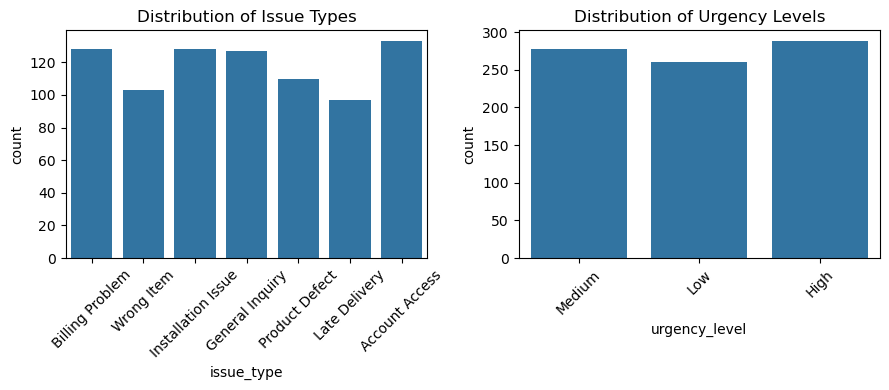

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Start a new figure
fig = plt.figure(figsize=(9, 4))

# First subplot: Issue Type
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='issue_type')
plt.title("Distribution of Issue Types")
plt.xticks(rotation=45)

# Second subplot: Urgency Level
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='urgency_level')
plt.title("Distribution of Urgency Levels")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


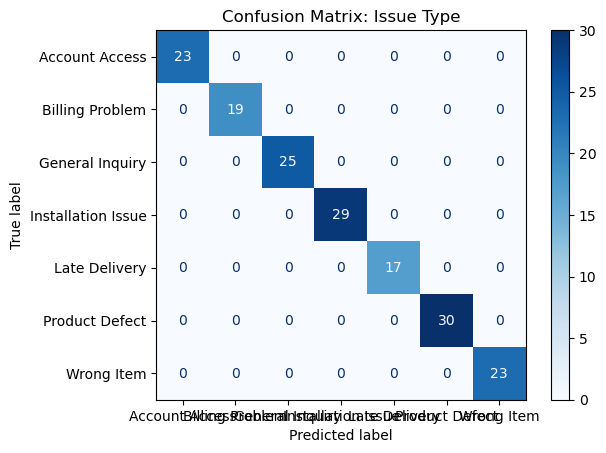

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for Issue Type
issue_preds = issue_model.predict(X_test1)
ConfusionMatrixDisplay.from_predictions(y_test1, issue_preds, cmap='Blues')
plt.title("Confusion Matrix: Issue Type")
plt.show()


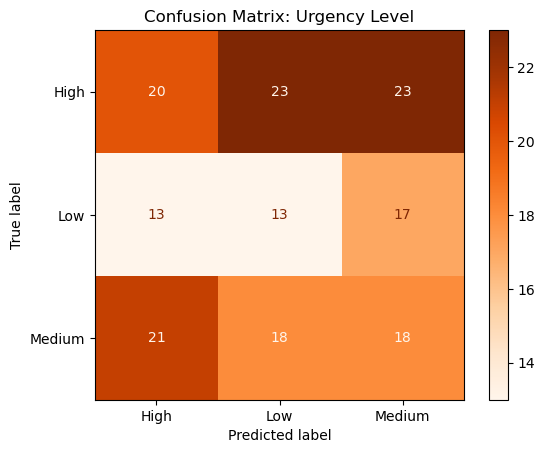

In [43]:
urgency_preds = urgency_model.predict(X_test2)
ConfusionMatrixDisplay.from_predictions(y_test2, urgency_preds, cmap='Oranges')
plt.title("Confusion Matrix: Urgency Level")
plt.show()
